In [1]:
# Import the necessary libraries
import scipy.io
import pandas as pd
import numpy as np

# Load the umist_cropped.mat file using scipy.io
mat = scipy.io.loadmat('umist_cropped.mat')

# Display the keys of the loaded .mat file to understand its structure
mat.keys()


dict_keys(['__header__', '__version__', '__globals__', 'facedat', 'dirnames'])

In [2]:
# Extract the facedat and dirnames
facedat = mat['facedat']
dirnames = mat['dirnames']

# Prepare a list to store flattened images and corresponding labels
image_list = []
labels = []

# Iterate over each entry in facedat and corresponding label in dirnames
for i in range(facedat.shape[1]):  # facedat[0, i] gives each set of images for a person
    image_set = facedat[0, i]      # Extract the 3D array of images for this person
    num_images = image_set.shape[-1]  # Get the number of images in this set

    for j in range(num_images):       # Loop over each image for the person
        image = image_set[:, :, j]    # Select individual 2D image
        image_flat = image.flatten()  # Flatten the image

        # Append flattened image to the list
        image_list.append(image_flat)

        # Extract label ('1a', '1b', ...) as a string and assign to each image
        labels.append(dirnames[0, i][0])

# Create a DataFrame with flattened images
data_group2 = pd.DataFrame(image_list)

# Add labels as a new column in the DataFrame
data_group2['label'] = labels

# Display the first few rows to verify the DataFrame structure
print(data_group2.head())


     0    1    2    3    4    5    6    7    8    9  ...  10295  10296  10297  \
0  233  234  234  233  234  232  232  168   99   78  ...    154    151    147   
1  234  234  234  234  233  232  202   98   79   77  ...    154    150    147   
2  234  234  234  234  233  230  225  109   85   84  ...    174    168    164   
3  234  234  234  234  234  234  234  232  229  205  ...    168    162    157   
4  234  234  234  234  234  234  234  234  229  211  ...    176    170    164   

   10298  10299  10300  10301  10302  10303  label  
0    143    140    141    141    140    136     1a  
1    141    140    137    138    137    137     1a  
2    157    152    151    148    145    145     1a  
3    155    150    144    144    142    143     1a  
4    162    157    152    150    148    148     1a  

[5 rows x 10305 columns]


In [3]:
#sepate the features and the target variable
data_group2_features = data_group2.iloc[:, :-1]
data_group2_target = data_group2.iloc[:, -1]

In [4]:
# Check for Duplicate Entries
# Ensure there are no duplicate entries in the dataset that could bias the model.

import pandas as pd


# Check for duplicate entries
duplicate_count = data_group2.duplicated().sum()
print(f"Number of duplicate entries: {duplicate_count}")


Number of duplicate entries: 10


In [5]:
# Check for duplicate entries
duplicate_count = data_group2.duplicated().sum()
print(f"Number of duplicate entries before removing: {duplicate_count}")
# Remove duplicates if any
if duplicate_count > 0:
    data_group2 = data_group2.drop_duplicates()
    data_group2_features = data_group2.iloc[:, :-1].values / 255.0
    data_group2_target = data_group2.iloc[:, -1].values
    X_images = data_group2_features.reshape(-1, 112, 92, 1)
    print("Duplicate entries removed and data updated.")
else:
    print("No duplicate entries found.")

#shape of the data
print('data shape', data_group2.shape)

#count the duplicate entries
print('duplicate entries after removing', data_group2.duplicated().sum())


Number of duplicate entries before removing: 10
Duplicate entries removed and data updated.
data shape (565, 10305)
duplicate entries after removing 0


In [6]:
#
# !pip install albumentations

# Data Augmentation using Albumentations
# Set up data augmentation using Albumentations to enhance the diversity of the training dataset.

import albumentations as A

# Data Augmentation setup
transform = A.Compose([
    A.Rotate(limit=10, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2)])

# Note: Albumentations will be applied during training
print("Data augmentation setup completed.")

import numpy as np

# Determine the maximum count to balance the dataset
target_count = data_group2['label'].value_counts().max()
print("Target image count for each label:", target_count)

# Balance the dataset by augmenting images
balanced_images = []
balanced_labels = []

# Create a set to track already added images (flattened version for comparison)
added_images = set()

# Iterate over each unique label to augment images where needed
for label in data_group2['label'].unique():
    label_images = data_group2[data_group2['label'] == label].drop(columns=['label']).values
    label_count = label_images.shape[0]
    print(f"Current count for label '{label}': {label_count}")

    # Reshape each flattened image back to original dimensions
    reshaped_images = [img.reshape(112, 92, 1) for img in label_images]  # Assuming 112x92 image size

    # Convert list to numpy array
    reshaped_images = np.array(reshaped_images)

    # Add original images to balanced dataset, check for uniqueness
    for img in reshaped_images:
        img_flattened = img.flatten()
        if tuple(img_flattened) not in added_images:  # Check if image is not already added
            balanced_images.append(img_flattened)
            balanced_labels.append(label)
            added_images.add(tuple(img_flattened))  # Mark image as added

    # Generate augmented images if current count is less than target
    if label_count < target_count:
        n_needed = target_count - label_count
        print(f"Generating {n_needed} additional images for label '{label}'")

        # Randomly select and augment images until we reach the required number
        for _ in range(n_needed):
            while True:  # Continue until a unique augmented image is found
                img = reshaped_images[np.random.choice(len(reshaped_images))]  # Randomly select an image
                augmented = transform(image=img.squeeze())['image']
                augmented_img = augmented.reshape(112, 92)

                # Flatten the augmented image for uniqueness check
                augmented_img_flattened = augmented_img.flatten()

                # Check if the augmented image has already been added
                if tuple(augmented_img_flattened) not in added_images:
                    balanced_images.append(augmented_img_flattened)
                    balanced_labels.append(label)
                    added_images.add(tuple(augmented_img_flattened))  # Mark as added
                    break  # Break out of the loop when a unique image is found

# Create a new balanced DataFrame
balanced_data_group2 = pd.DataFrame(balanced_images)
balanced_data_group2['label'] = balanced_labels

# Verify the balancing
print(balanced_data_group2['label'].value_counts())

# Check for duplicates after augmentation
print('Duplicate values after augmentation:', balanced_data_group2.duplicated().sum())


c:\Users\ezzar\anaconda3\envs\Semester2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data augmentation setup completed.
Target image count for each label: 48
Current count for label '1a': 38
Generating 10 additional images for label '1a'
Current count for label '1b': 25
Generating 23 additional images for label '1b'
Current count for label '1c': 26
Generating 22 additional images for label '1c'
Current count for label '1d': 24
Generating 24 additional images for label '1d'
Current count for label '1e': 26
Generating 22 additional images for label '1e'
Current count for label '1f': 23
Generating 25 additional images for label '1f'
Current count for label '1g': 19
Generating 29 additional images for label '1g'
Current count for label '1h': 22
Generating 26 additional images for label '1h'
Current count for label '1i': 20
Generating 28 additional images for label '1i'
Current count for label '1j': 32
Generating 16 additional images for label '1j'
Current count for label '1k': 34
Generating 14 additional images for label '1k'
Current count for label '1l': 34
Generating 14 

In [7]:

#sepate the features and the target variable
data_balanced_group2_features = balanced_data_group2.iloc[:, :-1]
data_balanced_group2_target = balanced_data_group2.iloc[:, -1]
# Normalize Pixel Values
# Normalize the pixel values to a range of [0, 1] to facilitate faster and more effective training.
data_balanced_group2_features = data_balanced_group2_features / 255.0
print(data_balanced_group2_features.head())
#min max of all the columns except the label column
print('min', data_balanced_group2_features.iloc[:, :-1].min().min())
print('max', data_balanced_group2_features.iloc[:, :-1].max().max())


      0         1         2         3         4         5         6      \
0  0.913725  0.917647  0.917647  0.913725  0.917647  0.909804  0.909804   
1  0.917647  0.917647  0.917647  0.917647  0.913725  0.909804  0.792157   
2  0.917647  0.917647  0.917647  0.917647  0.913725  0.901961  0.882353   
3  0.917647  0.917647  0.917647  0.917647  0.917647  0.917647  0.917647   
4  0.917647  0.917647  0.917647  0.917647  0.917647  0.917647  0.917647   

      7         8         9      ...     10294     10295     10296     10297  \
0  0.658824  0.388235  0.305882  ...  0.615686  0.603922  0.592157  0.576471   
1  0.384314  0.309804  0.301961  ...  0.619608  0.603922  0.588235  0.576471   
2  0.427451  0.333333  0.329412  ...  0.705882  0.682353  0.658824  0.643137   
3  0.909804  0.898039  0.803922  ...  0.682353  0.658824  0.635294  0.615686   
4  0.917647  0.898039  0.827451  ...  0.729412  0.690196  0.666667  0.643137   

      10298     10299     10300     10301     10302     10303  
0  0

In [8]:
# Stratified Sampling
# Split the dataset into training, validation, and testing sets using stratified sampling to maintain class distribution across all subsets.

#dataframe to array 
data_balanced_group2_featuress = data_balanced_group2_features.values
data_balanced_group2_targets = data_balanced_group2_target.values 

from sklearn.model_selection import StratifiedShuffleSplit

# Initialize StratifiedShuffleSplit for the first split (train + temp) 60% train, 40% temp
s1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=44)
for train_index, temp_index in s1.split(data_balanced_group2_featuress, data_balanced_group2_targets):
    X_train, X_temp = data_balanced_group2_featuress[train_index], data_balanced_group2_featuress[temp_index]
    y_train, y_temp = data_balanced_group2_targets[train_index], data_balanced_group2_targets[temp_index]

# Initialize StratifiedShuffleSplit for the second split (validation/test)
s2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=44)
for val_index, test_index in s2.split(X_temp, y_temp):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (576, 10304) (576,)
Validation set shape: (192, 10304) (192,)
Test set shape: (192, 10304) (192,)


In [34]:
#One-Hot Encoding

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_group2 = le.fit_transform(y_train)
y_val_group2 = le.transform(y_val)
y_test_group2 = le.transform(y_test)


## T-sne

t-SNE transformed training set shape: (576, 2)


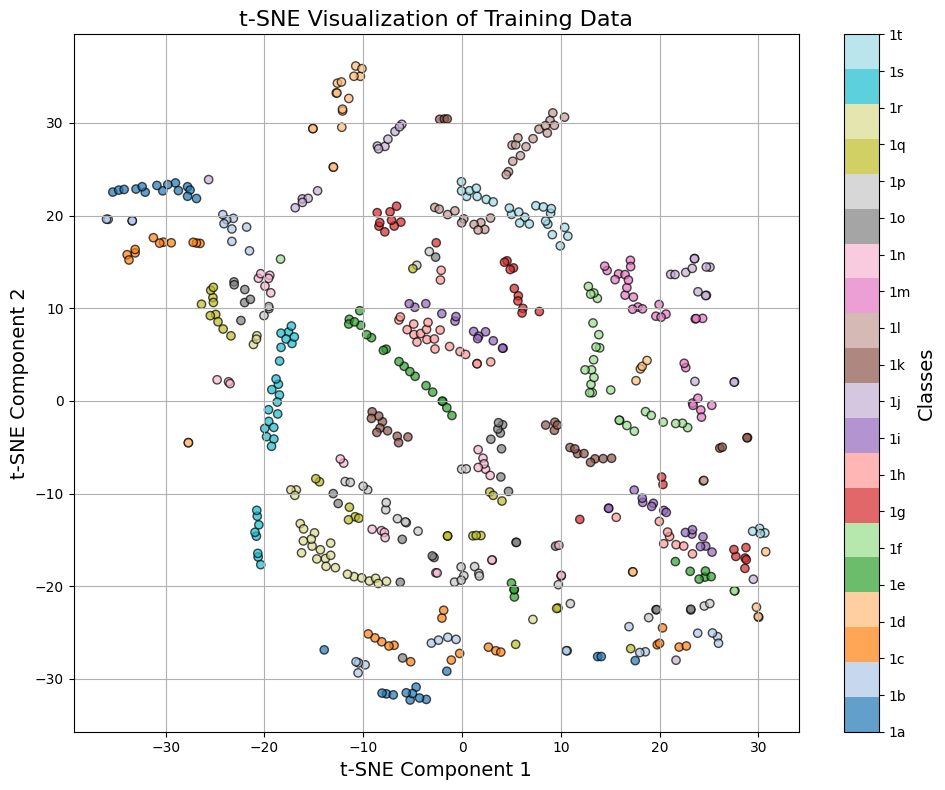

t-SNE transformed validation set shape: (192, 2)


In [29]:
#T-SNE
# Apply t-SNE to the Training Set
# Apply t-SNE to visualize the high-dimensional data in 2D space.

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder


# Step 3: Apply t-SNE 
tsne = TSNE(n_components=2, random_state=44)
X_train_tsne = tsne.fit_transform(X_train)
print("t-SNE transformed training set shape:", X_train_tsne.shape)

# Step 4: Visualize the t-SNE plot with encoded labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0], 
    X_train_tsne[:, 1], 
    c=y_train_group2, 
    cmap='tab20', 
    edgecolor='k', 
    alpha=0.7
)
plt.title("t-SNE Visualization of Training Data", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=14)
plt.ylabel("t-SNE Component 2", fontsize=14)

# Create a colorbar with class labels
cbar = plt.colorbar(scatter, ticks=range(len(le.classes_)))
cbar.set_label('Classes', fontsize=14)
cbar.set_ticklabels(le.classes_)

plt.grid(True)
plt.tight_layout()
plt.show()

# Apply t-SNE to the Validation and Test Sets
# Apply the same t-SNE transformation to the validation and test sets for consistency.

#tsne transformation of the validation set
X_val_tsne = tsne.fit_transform(X_val)
print("t-SNE transformed validation set shape:", X_val_tsne.shape)





# Clustering 


In [36]:
import numpy as np

# Save as .npy
np.save('X_train_tsne.npy', X_train_tsne)
np.save('X_val_tsne.npy', X_val_tsne)
np.save('y_train_group2.npy', y_train_group2)
np.save('y_val_group2.npy', y_val_group2)
np.save('y_test_group2.npy', y_test_group2)

# Load it back
X_train_tsne = np.load('X_train_tsne.npy')
X_val_tsne = np.load('X_val_tsne.npy')
y_train_group2 = np.load('y_train_group2.npy')
y_val_group2 = np.load('y_val_group2.npy')
